# F215089
## 20 January 2023
### Poor Attendance Program

- The poor attendance program imports the functions in Student_Att Notebook because the load_join_table and weekly_attendance function will be used in this program.
- This program finds out the disengaged students; these are students whose percentage weekly attendance is less than the department average. This program allows you to choose from 2 categories:
  - least disengaged students: to view this category you put 1 in the function
  - most disengaged students: to view this category you put 2 in the function
- It also allows you input what percentage of the category you want to view.
- The last cell has the function(main_poor_att) that makes use of all the functions in this program.
- It requires the senior tutor to input the  type of visual and percentage of the category to be viewed.

## Importing packages

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipynb
from ipynb.fs.defs.Student_Att import *# import functions used in Student Att

## Extracting poor attendance information

In [2]:
def average_weekly_module_attendance(dfData1, dfData2):
    """
    This function calculates the module's weekly 
    specific attendance summary   
    input:
        dfData1: the first module dataframe
        dfData1: the second module dataframe
    return:
        df_module1_summary: module one weekly attendance summary
        df_module2_summary: mpdule two weekly attendance summary     
    """
    
    df_module1_summary = dfData1.iloc[ : , 1 : ].mean(axis=0)# selecting all columns except student id 
    df_module2_summary = dfData2.iloc[ : , 1 : ].mean(axis=0)
    return df_module1_summary, df_module2_summary

In [3]:
def poor_attendance(dfData1, dfData2):
    """
    This function obtains the disengaged students in the modules    
    input:
        dfData1: the first module dataframe
        dfData2: the second module dataframe
    return:
        df_disengaged_student: a dataframe of the disengaged students
        department_average: the value of the department average     
    """    
    module1_weekly_att = weekly_attendance(dfData1)
    module2_weekly_att = weekly_attendance(dfData2)
    #joining the 2 modules together
    df_comb_module_weekly_attendance = pd.concat([module1_weekly_att, module2_weekly_att], axis=0)
    df_comb_average_module_attendance = (df_comb_module_weekly_attendance.groupby('student_id').agg('mean')).round()
    df_comb_average_module_attendance.reset_index(inplace=True)
    #convert the student_id column type to integer
    df_comb_average_module_attendance = df_comb_average_module_attendance.astype({"student_id": np.int32})
    df_comb_average_module_attendance.sort_values('student_id', ascending = True, inplace = True)
    df_comb_average_module_attendance.set_index("student_id", inplace = True)
    df_comb_average_module_attendance["Average"] = df_comb_average_module_attendance.iloc[:].mean(axis=1).round()
    department_average = df_comb_average_module_attendance.iloc[:, -1].mean().round()
    disengaged_student = []
    for i in range(len(df_comb_average_module_attendance)):
        if df_comb_average_module_attendance.iloc[i, -1] < department_average:
            disengaged_student.append(df_comb_average_module_attendance.iloc[i])
            df_disengaged_student = pd.DataFrame(disengaged_student)
            df_disengaged_student = df_disengaged_student.round()
            df_disengaged_student.sort_values("Average", ascending = True, inplace = True)
    return department_average , df_disengaged_student



In [4]:
def disengaged_students_table_subset(dfData, percent_input, type_visual):
    """
    This function obtains the disengaged dataframe  
    input:
        dfData: the dataframe of disengaged students
        percent_input: percentage of the least or most disengaged students 
                       you want to see
        type_visual: the type of visualisation you want to see: 
                    1: to view the least disengaged students
                    2: to view the most disengaged students
    return:
        df_least_disengaged: a dataframe of the least disengaged students
        df_most_disengaged: a dataframe of the most disengaged students    
    """ 
    num_rows = dfData.shape[0]
    #obtain the row number to start selecting from
    var = round((percent_input / 100) * num_rows)
    if type_visual == 1:
        df_least_disengaged = dfData.iloc[-var:,  :]
        return df_least_disengaged
    
    elif type_visual == 2:
        df_most_disengaged = dfData.iloc[0:var, :] 
        return df_most_disengaged  

In [5]:
def poor_attendance_visualisation(dfData1, dfData2, modulename1, modulename2, type_visual, percent_input):
    """
    This function obtains the visualises the disengaged students in the modules 
    
    input:
        dfData1: the first module dataframe
        dfData2: the second module dataframe
        modulename1: the name of the first module
        modulename2: the name of the second module
        type_visual: the type of visualisation you want to see: 
                    1: to see the least disengaged students
                    2: to see the most disengaged students
        percent_input: percentage of the least or most disengaged students 
                       you want to see
    return:
        styled_table_disengaged_students: a table of the disengaged students 
        with a color code of green in attendances that are higher than the 
        department attendance average
        fig: a graph showing the requested disengaged students     
    """    
    if type_visual == 1: 
        #dataframe of disengaged students
        department_average, disengaged_students = poor_attendance(dfData1, dfData2)
        disengaged_students_subset = disengaged_students_table_subset(disengaged_students,\
                                                                      percent_input, type_visual)
        disengaged_students_subset.index.names = ["student_id"]
        disengaged_students_subset.columns= ["Week1 %", "Week2 %", "Week3 %",\
                                              "Week4 %", "Week5 %", "Week6 %", "Average%"]
        #format the ouput apply colour code
        styled_table_disengaged_students = disengaged_students_subset.style.applymap\
        (lambda x:"background-color: green" if x > department_average else "").format('{:.1f}')
        #plotting the graph of disengaged students 
        weekly_mod1_pct_att = weekly_attendance(dfData1)#weekly attendance for module 1
        weekly_mod2_pct_att = weekly_attendance(dfData2)
        # weekly module summary for each module
        module1_summary, module2_summary =average_weekly_module_attendance(weekly_mod1_pct_att,\
                                                                           weekly_mod2_pct_att)
        # plot the weekly module summary on a graph
        fig, ax = plt.subplots()
        module1_summary.plot.line(x = "week", ax=ax, color='green', label=modulename1)
        module2_summary.plot.line(x = "week", ax=ax, color='blue', label=modulename2)
        #plot the disengaged students
        disengaged_students_graph = disengaged_students_subset.iloc[:, 0:6] #selects columns week1 to week6
        disengaged_students_graphT = disengaged_students_graph.transpose()
        disengaged_students_graphT.plot(marker = ".", linestyle = "none", ax=ax)
        # Add a title, legend and ticks to the plot
        ax.set_xlabel("Week Number")
        ax.set_ylabel("Attendance")
        ax.set_xticks([0, 1, 2, 3, 4, 5])
        ax.set_xticklabels(labels = ['1', '2', '3', '4', '5', '6'], 
                   rotation=0)
        ax.legend()
        plt.close()
        return styled_table_disengaged_students, fig 
    else:
        type_visual == 2
        #dataframe of disengaged students
        department_average, disengaged_students = poor_attendance(dfData1, dfData2)
        disengaged_students_subset = disengaged_students_table_subset(disengaged_students, \
                                                                      percent_input, type_visual)
        disengaged_students_subset.index.names = ["student_id"]
        disengaged_students_subset.columns= ["Week1 %", "Week2 %", "Week3 %", \
                                              "Week4 %", "Week5 %", "Week6 %", "Average%"]
        #format the ouput apply colour code
        styled_table_disengaged_students = disengaged_students_subset.style.applymap\
        (lambda x:"background-color: green"\
         if x > department_average else "").format('{:.1f}')
        #plotting the graph of disengaged students 
        weekly_mod1_pct_att = weekly_attendance(dfData1)# weekly attendance for module 1
        weekly_mod2_pct_att = weekly_attendance(dfData2)
        # weekly module summary for each module
        module1_summary, module2_summary = average_weekly_module_attendance(weekly_mod1_pct_att,\
                                                                           weekly_mod2_pct_att)
        # plot the weekly module summary on a graph
        fig, ax = plt.subplots()
        module1_summary.plot.line(x = "week", ax=ax, color='green', label=modulename1)
        module2_summary.plot.line(x = "week", ax=ax, color='blue', label=modulename2)
        #plot the disengaged students
        disengaged_students_graph = disengaged_students_subset.iloc[:, 0:6] #selects columns week1 to week6
        disengaged_students_graphT = disengaged_students_graph.transpose()
        disengaged_students_graphT.plot(marker = ".", linestyle = "none", ax=ax)
        # Add a title, legend and ticks to the plot
        ax.set_xlabel("Week Number")
        ax.set_ylabel("Attendance")
        ax.set_xticks([0, 1, 2, 3, 4, 5])
        ax.set_xticklabels(labels = ['1', '2', '3', '4', '5', '6'], 
                   rotation=0)
        ax.legend()
        plt.close()
        return styled_table_disengaged_students, fig
     

## Applying the functions on the given dataset

,Week1 %,Week2 %,Week3 %,Week4 %,Week5 %,Week6 %,Average%
student_id,,,,,,,
168,50.0,75.0,50.0,75.0,75.0,100.0,71.0
114,50.0,75.0,50.0,100.0,50.0,100.0,71.0
6,75.0,50.0,50.0,50.0,100.0,100.0,71.0
181,50.0,100.0,75.0,75.0,25.0,100.0,71.0


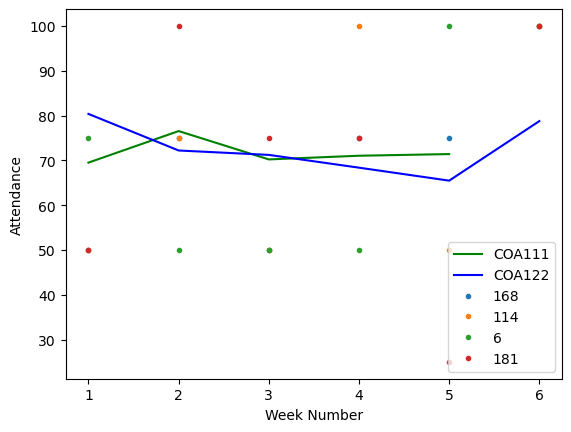

In [6]:
def main_poor_att(type_visual, percent_input):
    dfCOA111 = load_join_table(sqlstr="""
    SELECT T.*, C.week
    FROM COA111T T INNER JOIN COA111Sessions C
    ON T.sess_id = C.sess_id;
    """)
    dfCOA122 = load_join_table(sqlstr="""
    SELECT T.*, C.week
    FROM COA122T T INNER JOIN COA122Sessions C
    ON T.sess_id = C.sess_id;
    """)
    table, fig = poor_attendance_visualisation(dfCOA111, dfCOA122, \
                                               "COA111", "COA122",type_visual, percent_input)
    return table, fig

#calling the main_poor_att function
table, fig = main_poor_att(1,5)
display(table)
display(fig)